99.0
200.1534529627988
hd
73.56827992401757
169.68809823651117
Starting HD windows time step [days]: [22.631736821593744, 42.42075633987144]
HD windows duration [days]: [<Quantity 119.33919771 d>, <Quantity 100.49555767 d>]
Timestep 864.0000 ss
Run time 1267.74s/21.13m
111.2144763443167


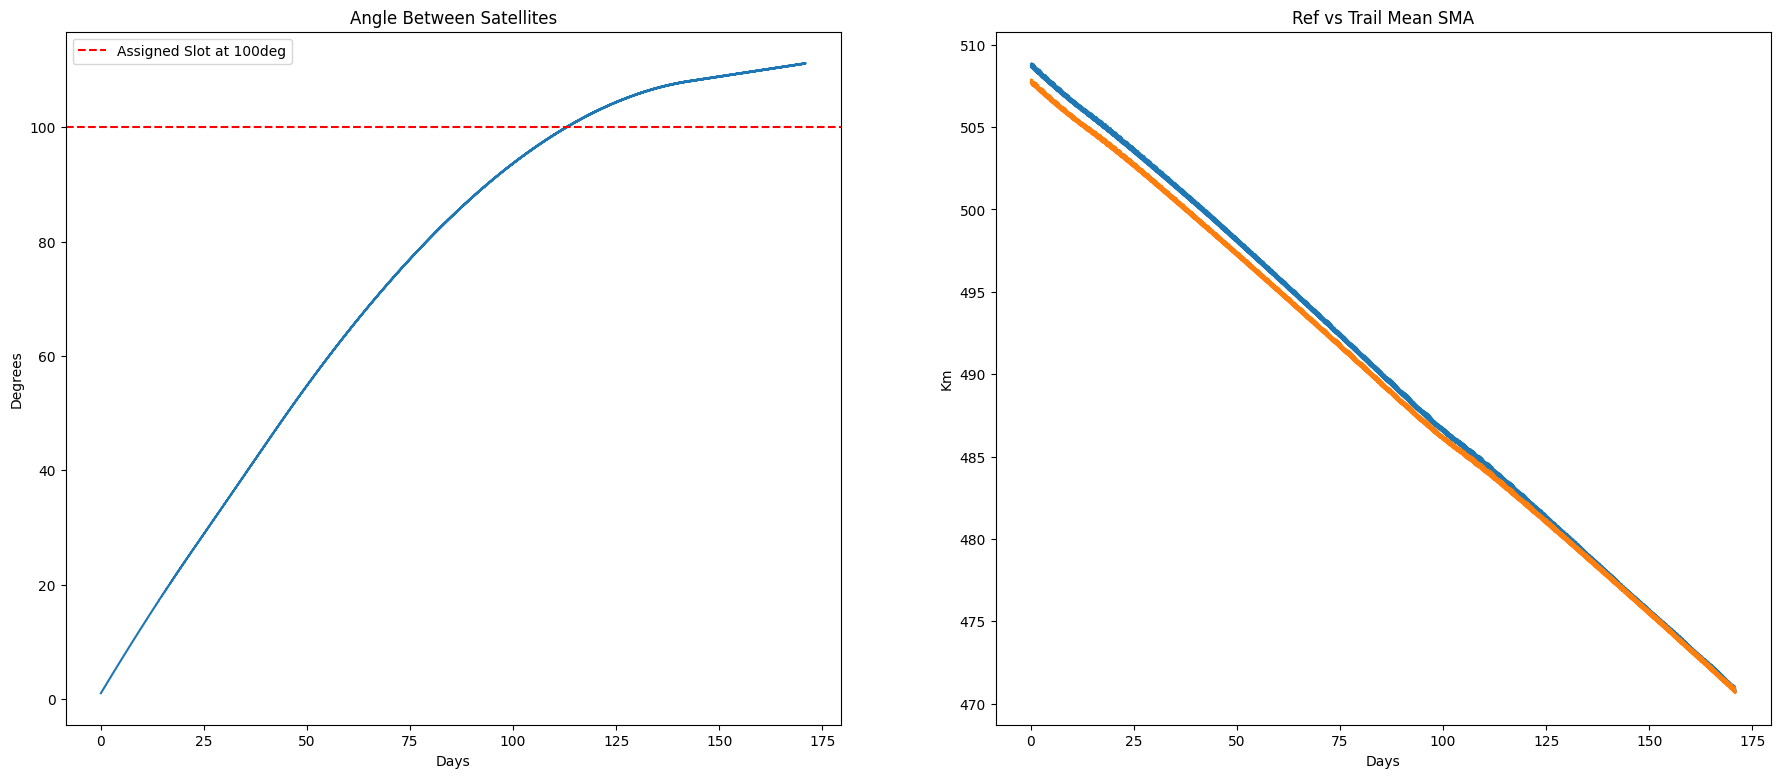

In [11]:
## DDIFFERENTIAL DRAG ALGORITHM BASED ON FOSTER THEORY

import time

import numpy as np

from astropy import units as u
from astropy.time import Time, TimeDelta

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

import matplotlib.pyplot as plt
from poliastro.plotting import OrbitPlotter3D

from datetime import datetime
from osc2mean_dd import osc2mean
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high

toc = time.time()

## Input parameters
h = 510
delta_a = 1     # delta_a always is a positive value
delta_nu = -1   # reasonably, delta_nu should be a negative value
assignment = 100%360

## Orbital data
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')


reference_orbit_0 = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit_0 = Orbit.from_classical(
    Earth,
    (a.value+delta_a)<<u.km,
    ecc,
    inc,
    raan,
    argp,
    (nu.value+delta_nu)<<u.deg,
    epoch
    )

reference_orbit = reference_orbit_0
trailing_orbit = trailing_orbit_0


## Propagation data
time_step = 864<<u.s
pred_days = assignment-delta_nu

refsmalist = []
refsmalist_mean = []
trailsmalist = []
trailsmalist_mean = []

elapsedsecs = []
secs = 0
angle_list = []
hd_window = []
hd_duration = []

start_date_prop = epoch
ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
trail_mean = osc2mean(a.value+delta_a, ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu)
trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu<<u.deg), epoch)

mans = 2


## Differential drag algorithm + propagation
for i in range(mans):

    theta_err = (assignment - argl_difference(reference_orbit, trailing_orbit))%360
    pred_days = theta_err
    # tra_orb_pred = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    # tra_pred_mean = osc2mean(tra_orb_pred.a.value, tra_orb_pred.ecc.value, tra_orb_pred.inc.to_value(u.deg), tra_orb_pred.raan.to_value(u.deg), tra_orb_pred.argp.to_value(u.deg), tra_orb_pred.nu.to_value(u.deg))
    # tra_orb_pred_mean = Orbit.from_classical(Earth, tra_pred_mean[0]<<u.km, tra_pred_mean[1]<<u.one, tra_pred_mean[2]<<u.deg, tra_pred_mean[3]<<u.deg, tra_pred_mean[4]<<u.deg, tra_orb_pred.nu.to(u.deg), tra_orb_pred.epoch)
    for attempts in range(2):
        print(pred_days)
        tra_orb_pred_high = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
        tra_pred_mean_high = osc2mean(tra_orb_pred_high.a.value, tra_orb_pred_high.ecc.value, tra_orb_pred_high.inc.to_value(u.deg), tra_orb_pred_high.raan.to_value(u.deg), tra_orb_pred_high.argp.to_value(u.deg), tra_orb_pred_high.nu.to_value(u.deg))
        tra_orb_pred_mean_high = Orbit.from_classical(Earth, tra_pred_mean_high[0]<<u.km, tra_pred_mean_high[1]<<u.one, tra_pred_mean_high[2]<<u.deg, tra_pred_mean_high[3]<<u.deg, tra_pred_mean_high[4]<<u.deg, tra_orb_pred_high.nu.to(u.deg), tra_orb_pred_high.epoch)

        tra_orb_pred_low = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
        tra_pred_mean_low = osc2mean(tra_orb_pred_low.a.value, tra_orb_pred_low.ecc.value, tra_orb_pred_low.inc.to_value(u.deg), tra_orb_pred_low.raan.to_value(u.deg), tra_orb_pred_low.argp.to_value(u.deg), tra_orb_pred_low.nu.to_value(u.deg))
        tra_orb_pred_mean_low = Orbit.from_classical(Earth, tra_pred_mean_low[0]<<u.km, tra_pred_mean_low[1]<<u.one, tra_pred_mean_low[2]<<u.deg, tra_pred_mean_low[3]<<u.deg, tra_pred_mean_low[4]<<u.deg, tra_orb_pred_low.nu.to(u.deg), tra_orb_pred_low.epoch)

        theta_dot_dot = (tra_orb_pred_mean_high.n.to(u.deg/u.s) - tra_orb_pred_mean_low.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)  

        #theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)
        t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = ((theta_err - theta_hd.value)%360 / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))) #- t_hd.value 

        pred_days = ((t_wait+t_hd.value)/(60*60*24))**(1+((trail_mean_orbit.a.value-Earth.R_mean.to_value(u.km)+(trail_mean_orbit.a.value-ref_mean_orbit.a.value))/10000))

    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    if i == 0:
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))
        print('hd')
    else:
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
       

    hd_window.append((secs+t_wait)/(60*60*24))
    hd_duration.append(t_hd.to(u.day))


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        refsmalist.append(ref_from_ephem.a.value)
        trailsmalist.append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean.append(trail_mean[0])
        
        angle_list.append(argl_difference(ref_from_ephem, trail_from_ephem))

        elapsedsecs.append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

    ref_mean_orbit = Orbit.from_classical(
                                    Earth, 
                                    ref_mean[0]<<u.km, 
                                    ref_mean[1]<<u.one, 
                                    ref_mean[2]<<u.deg, 
                                    ref_mean[3]<<u.deg, 
                                    ref_mean[4]<<u.deg, 
                                    reference_orbit.nu.to(u.deg), 
                                    reference_orbit.epoch
                                    )
    trail_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            trail_mean[0]<<u.km, 
                                            trail_mean[1]<<u.one, 
                                            trail_mean[2]<<u.deg, 
                                            trail_mean[3]<<u.deg, 
                                            trail_mean[4]<<u.deg, 
                                            trailing_orbit.nu.to(u.deg), 
                                            trailing_orbit.epoch
                                            )   


    if i > 0:
        num_hd = int(t_hd.value / time_step.value)
        tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

        reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))

        for t in range(len(tofs_hd)):

            secs += time_step.value

            ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
            trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

            refsmalist.append(ref_from_ephem.a.value)
            trailsmalist.append(trail_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)

            )
            trail_mean = osc2mean(
                trail_from_ephem.a.value,
                trail_from_ephem.ecc.value,
                trail_from_ephem.inc.to_value(u.deg),
                trail_from_ephem.raan.to_value(u.deg),
                trail_from_ephem.argp.to_value(u.deg),
                trail_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean.append(ref_mean[0])
            trailsmalist_mean.append(trail_mean[0])
            
            angle_list.append(argl_difference(ref_from_ephem, trail_from_ephem))

            elapsedsecs.append(secs)

        reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
        trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


        ref_mean = osc2mean(
            reference_orbit.a.value, 
            reference_orbit.ecc.value, 
            reference_orbit.inc.to_value(u.deg), 
            reference_orbit.raan.to_value(u.deg), 
            reference_orbit.argp.to_value(u.deg), 
            reference_orbit.nu.to_value(u.deg)
            )
        ref_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            ref_mean[0]<<u.km, 
                                            ref_mean[1]<<u.one, 
                                            ref_mean[2]<<u.deg, 
                                            ref_mean[3]<<u.deg, 
                                            ref_mean[4]<<u.deg, 
                                            reference_orbit.nu.to(u.deg), 
                                            reference_orbit.epoch
                                            )

        trail_mean = osc2mean(
            trailing_orbit.a.value, 
            trailing_orbit.ecc.value, 
            trailing_orbit.inc.to_value(u.deg), 
            trailing_orbit.raan.to_value(u.deg), 
            trailing_orbit.argp.to_value(u.deg), 
            trailing_orbit.nu.to_value(u.deg)
            )
        trail_mean_orbit = Orbit.from_classical(
                                                Earth, 
                                                trail_mean[0]<<u.km, 
                                                trail_mean[1]<<u.one, 
                                                trail_mean[2]<<u.deg, 
                                                trail_mean[3]<<u.deg, 
                                                trail_mean[4]<<u.deg, 
                                                trailing_orbit.nu.to(u.deg), 
                                                trailing_orbit.epoch
                                                )

    start_date_prop = reference_orbit.epoch
    

## Propagation without any control
reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

t_prop = (60*60*24*7*4)<<u.s

num_prop = int(t_prop.value / time_step.value)
tofs_prop = TimeDelta(np.linspace(0, t_prop, num=num_prop))

reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))

for t in range(len(tofs_prop)):

    secs += time_step.value

    ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
    trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

    refsmalist.append(ref_from_ephem.a.value)
    trailsmalist.append(trail_from_ephem.a.value)

    ref_mean = osc2mean(
        ref_from_ephem.a.value,
        ref_from_ephem.ecc.value,
        ref_from_ephem.inc.to_value(u.deg),
        ref_from_ephem.raan.to_value(u.deg),
        ref_from_ephem.argp.to_value(u.deg),
        ref_from_ephem.nu.to_value(u.deg)

    )
    trail_mean = osc2mean(
        trail_from_ephem.a.value,
        trail_from_ephem.ecc.value,
        trail_from_ephem.inc.to_value(u.deg),
        trail_from_ephem.raan.to_value(u.deg),
        trail_from_ephem.argp.to_value(u.deg),
        trail_from_ephem.nu.to_value(u.deg)
    )

    refsmalist_mean.append(ref_mean[0])
    trailsmalist_mean.append(trail_mean[0])

    angle_list.append(argl_difference(ref_from_ephem, trail_from_ephem))

    elapsedsecs.append(secs)


## Plots
elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

trail_mean_altitudes = []
ref_mean_altitudes = []
for sma in range(len(trailsmalist_mean)):
    trail_mean_altitudes.append(trailsmalist_mean[sma] - Earth.R_mean.to_value(u.km))
    ref_mean_altitudes.append(refsmalist_mean[sma] - Earth.R_mean.to_value(u.km))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,trail_mean_altitudes,label='Trail')
ax[0,1].plot(elapsed_days,ref_mean_altitudes,label='Ref')
ax[0,1].set_title('Ref vs Trail Mean SMA')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')


print(f'Starting HD windows time step [days]: {hd_window}')
print(f'HD windows duration [days]: {hd_duration}')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
print(angle_list[-1])
plt.show()

In [7]:
angle_list[-1]

112.3591460539543